# Anomaly Detection

- Create a 'vitality' feature, which is an average of all the vitality metrics.
- Plot a graph of this over time
- Determine the standard deviation & mean
- Identify specific points which fall out of (mean +/- sigma), and return the 7 day period immediately preceeding this (separate function).
    - One function which detects anomalies, and another function which takes the anomalies, and uses the date feature to extract 7 (or otherwise specified) periods of measured metric data immediately preceding the anomaly's date.
    - Quantify changes in correlated metrics (% change in the last few days compared to a global average or baseline)

### Creating the 'vitality' aggregated feature.

In [399]:
import pandas as pd
import numpy as np
import math

data = pd.read_csv('sample_agg_health_and_checkin_data.csv')

vitality_metrics = ["generalFeeling", "mood", "focus", "energy"]

measured_metrics = [col for col in data.columns.drop('startOfDate') if col not in vitality_metrics]

In [400]:
# Given a list of health data, engineers the 'vitality' feature, which is the average of all vitality metrics recorded 
# for a given day, excluding '0' or NaN values for each row considered when applying a column-wise mean.
# The result is an array of shape (-1, 2), where each row contains the original data frame index, so that we can 
# re-merge at a later stage and extract the measured_metrics, as well as the actual vitality for the day.
def summarise_vitality(data, vitality_metrics):
    vitality = np.array([ np.mean(x[np.logical_not(np.isnan(x))]) for x in data[vitality_metrics].values ]).reshape(-1, 1)
    indeces = np.array(data.index.to_series().values).reshape(-1, 1)
    return np.append(indeces, vitality, axis=1)

In [401]:
vitality = summarise_vitality(data, vitality_metrics)

# Add vitality to the data.
data["vitality"] = vitality[:, 1]

In [439]:
# Fill in all missing NaN weight values by linearly interpolating.
data["weight"] = data["weight"].interpolate(limit_direction='both')

### Detecting anomalies in a given metric, such as vitality.

In [599]:
def detect_anomaly_indeces(data, desired_metric, std_deviations=1):

    sigma = data[desired_metric].std()
    mu = data[desired_metric].mean()

    upper_bound = mu + sigma*std_deviations
    lower_bound = mu - sigma*std_deviations

    anomaly_indeces = np.where((data[desired_metric] < lower_bound) | (data[desired_metric] > upper_bound))
    
    return anomaly_indeces[0]

In [441]:
# For each anomaly detected, return the immediate 'X' day period preceding the occurrance of the anomaly.
# We merge the vitality for each day with all the other metrics observed or measured on a particular day / row.
def get_data_preceding_anomaly(data, anomaly_idx, preceding_num_days=7):
    return data.iloc[(anomaly_idx-preceding_num_days if anomaly_idx > preceding_num_days else 0):anomaly_idx]

preceding_data = get_data_preceding_anomaly(data, 63)

In [580]:
import matplotlib.pyplot as plt

# For each measured metric preceding an anomaly, find the most correlated features which contribute to the anomaly itself. 
# For this, we will need to append 'vitality' as an extra column on the pandas dataframe.
def get_most_correlated_complement(corr_matrix, metric):
    most_corr_metric, most_corr_val = ("", 0)
    for colName, value in corr_matrix[metric].iteritems():
        if (colName == metric or colName in vitality_metrics): 
            continue
        if (abs(value) > abs(most_corr_val)):
            most_corr_metric, most_corr_val = (colName, value)
    return (most_corr_metric, most_corr_val)

# Given a correlation matrix and a desired metric, returns a list of metrics and their correlation 
# scores, sorted in terms of the highest correlation.
def fetch_most_correlated_to(data_df, desired_metric):
#     print(data_df, desired_metric)
#     corr_matrix = data.corr()
    metrics_to_select = measured_metrics + [desired_metric]
#     print(f'Metrics to select: {metrics_to_select}')
#     print(f'Subset of measured {data_df[measured_metrics].columns}')
#     print(f'Subset of selected {data_df[metrics_to_select].columns}')
#     print(f'Correlation matrix for metrics_to_select {data_df[metrics_to_select].corr()}')
    correlation_matrix = data_df[metrics_to_select].corr()[desired_metric]
    correlation_matrix_df = pd.DataFrame(correlation_matrix)
    
#     print('Correlation Matrix', correlation_matrix_df)
    
    sorted_abs_corr_matrix_df = pd.DataFrame(correlation_matrix.abs()).sort_values(desired_metric, ascending=False)
    
#     print('Sorted (abs) corr matrix', sorted_abs_corr_matrix_df)
    
    # After sorting the correlation matrix using absolute values, we need to 'merge' back in the negative
    # values wherever they also apply. We keep all key in the sorted_abs_corr_matrix so that we can 
    # preserve the index ordering which we computed during the sort method applied above.
    sorted_corr_matrix_df = sorted_abs_corr_matrix_df.join(other=correlation_matrix_df, on=sorted_abs_corr_matrix_df.index, how='left', lsuffix="_abs").drop(f'{desired_metric}_abs', axis=1)
    
#     print("Sorted corr matrix", sorted_corr_matrix_df)
        
    # Return all corrleated metrics, excluding 'vitality' which is trivially '1' by default.
    return sorted_corr_matrix_df

# Given a data frame, determines the % change in each column when compared to the global mean, as well as the 
# start of the subset period, by fitting a line and determining the % change between the first and last point 
# of the fitted line.
def determine_global_percentage_change_for_subset(all_data, subset_data):
    return pd.DataFrame((subset_data.mean() / all_data.mean()) - 1)

# Determines the local percentage change for a subset of the data, by fitting a line of best fit and determining 
# the relative change between the first and the last value.
def determine_local_percentage_change_for_subset(subset_data):
    
    x_mean = preceding_data.index.values.mean()
    x_centered = (preceding_data.index.values - x_mean)

    y_mean = preceding_data.mean()
    y_centered = preceding_data.drop("startOfDate", axis=1) - y_mean

    m = (x_centered.reshape(-1, 1) * y_centered).sum() / (x_centered ** 2).sum()

    b = y_mean - m * x_mean

    lobf_first_point = m * preceding_data.index.values[0] + b
    lobf_last_point = m * preceding_data.index.values[-1] + b

    local_percentage_change = lobf_last_point / lobf_first_point

    return pd.DataFrame(local_percentage_change - 1)
    
# Obtains correlated metrics along with the % change in each correlated metric from the global average. 
# These are sorted by an 'importance' ranking which weights the correlation by the percentage change.
# Returns all metrics with an importance greater than or equal to 0.4.
def fetch_most_important_metrics_related_to(all_data, subset_data, desired_metric, importance_threshold=0.4):
    most_corr_metrics = fetch_most_correlated_to(subset_data, desired_metric)
    global_percentage_change_for_subset = determine_global_percentage_change_for_subset(all_data, subset_data)
    local_percentage_change_for_subset = determine_local_percentage_change_for_subset(subset_data)
#     print('Most correlated metrics', most_corr_metrics)
#     print('Percentage change for subset', percentage_change_for_subset)
    joined_df = most_corr_metrics
    joined_df["local_percentage_change"] = local_percentage_change_for_subset
    joined_df["global_percentage_change"] = global_percentage_change_for_subset
    joined_df.columns = ["correlation", "local_percentage_change", "global_percentage_change"]
    
    # Drop the desired_metric column.
    joined_df = joined_df.drop(desired_metric, axis=0)
    
    # Add an 'importance' column which weights each correlated metric by the percentage change which occured
    # (both globally, and locally).
    #
    # We take into account the percentage change, as a correlation in and of itself isn't as useful out side 
    # of the context of a recent change. Indication of recent change would enable awareness and allow us to take action.
    joined_df['importance'] = joined_df["correlation"].abs() * joined_df["global_percentage_change"].abs() * joined_df["local_percentage_change"].abs()
    joined_df['importance'] = joined_df['importance'] / joined_df['importance'].max()
    
    return joined_df.sort_values(by='importance', ascending=False)

# # Fetch the most correlated metrics, and display a comparison for each.
def fetch_most_correlated_pairs(data):
    corr = data.corr()
    correlated_metrics = []
    for col in corr.columns:
        pair, corrVal = get_most_correlated_complement(corr, col)
        if ((col, pair, corrVal) not in correlated_metrics or (pair, col, corrVal) not in correlated_metrics):
            correlated_metrics.append((col, pair, corrVal))
    return correlated_metrics

# Compare metrics which are most correlated to the desired metric visually, displaying the values for both 
# metrics across time, as well as labelling the correlation between the two metrics.
def compare_most_correlated_to_visually(data, desired_metric, max_num_correlated_metrics=3):
    
    most_correlated_metrics = fetch_most_correlated_to(data, desired_metric)
    most_correlated_metrics = list(zip(most_correlated_metrics.index, most_correlated_metrics.values.reshape(-1)))[1:]
    if max_num_correlated_metrics > len(most_correlated_metrics):
        max_num_correlated_metrics = len(most_correlated_metrics)
        
    # Fetch the `max_num_correlated_metrics` top most correlated metrics, skipping the first which is
    # trivially the desired_metric itself.
    most_correlated_metrics = most_correlated_metrics[0:max_num_correlated_metrics]
    
    plot_idx = 0
    for correlated_metric, corr_score in most_correlated_metrics:
        plt.figure(plot_idx)
        compare_metrics(data, desired_metric, correlated_metric, corr_score=corr_score)
        plot_idx += 1
        
def compare_most_correlated_visually(data):
    correlated_metrics = fetch_most_correlated_pairs(data)
    plotIndex = 0
    for (metricOne, metricTwo, _) in correlated_metrics:
        plt.figure(plotIndex)
        plotIndex += 1
        compare_metrics(data, metricOne, metricTwo)
        
# Plotting restingHeartRate against the 4 vitality indicators.
def compare_metrics(df, metricOne, metricTwo, corr_score=None):
    feelingVHR = df[[metricOne, metricTwo]].dropna()
    metricOneMax = feelingVHR[metricOne].max()
    metricTwoMax = feelingVHR[metricTwo].max()
    plt.plot(feelingVHR[metricOne] / metricOneMax)
    plt.plot(feelingVHR[metricTwo] / metricTwoMax)
    plt.xlabel('Day')
    plt.ylabel('Normalised value')
    if corr_score is not None:
        plt.text((feelingVHR.index.min() + feelingVHR.index.max()) / 2, 1, f'Correlation: {corr_score}', horizontalalignment='center', verticalalignment='center')
    plt.legend()

In [585]:
important_metrics = fetch_most_important_metrics_related_to(data, get_data_preceding_anomaly(data, 14), "vitality")
important_metrics.loc[important_metrics["importance"] > 0.4].index.values

array(['activeEnergyBurned', 'basalEnergyBurned', 'dietaryProtein'],
      dtype=object)

1.2371207559121735

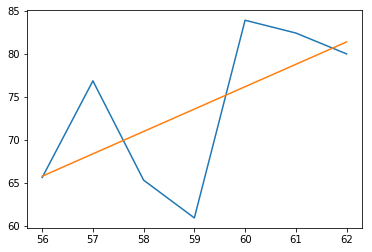

In [512]:
# TEMP: determining the lobf using sample preceding data.    
m = ((preceding_data.index.values - preceding_data.index.values.mean()) * (preceding_data["hrv"] - preceding_data["hrv"].mean())).sum() / \
((preceding_data.index.values - preceding_data.index.values.mean()) ** 2).sum()

b = preceding_data["hrv"].mean() - m*preceding_data.index.values.mean()

m * preceding_data.index.values[0] + b

plt.plot(preceding_data["hrv"])
plt.plot(preceding_data.index.values, preceding_data.index.values *m+b)

first = preceding_data.index.values[0]*m + b
last = preceding_data.index.values[-1]*m + b

(last / first)

### Extracting most relevant preceding data using the most important metrics.

Now that the most 'important' metrics can be computed for any length subset of data preceding some anomaly, we can extract a time series for the most important features contributing to the anomaly.

We can do this by extracting all metrics obtained by the `fetch_important_metrics_related_to` method which exceed an importance of `0.4`. This is an arbitrary parameter which appears to yield good results empirically.

After extracting all metrics, we can then construct a dictionray of the following format for some given anomaly:

```python
{
    "anomaly_index": Number,
    "anomaly_value": Number,
    "preceding_data": [DataFrame],
    "most_important_metrics": [DataFrame], # This would contain the % change, correlation, and importance.
    "most_important_preceding_data": [DataFrame] # This would be the 'preceding_data' frame filtered out by the most important metrics.
}
```

In [604]:
# Given the data, fetch the anomalies and the preceding data as an array of dictionaries
# {
#     anomaly_idx,
#     anomaly_value,
#     preceding_data,
#     most_important_metrics,
#     most_important_preceding_data
# }
def fetch_anomalies_and_preceding_data(data, desired_metric="vitality", preceding_num_days=7, std_deviations=1, importance_threshold=0.4):
    
    anomalies = []
    
    anomaly_idxs = detect_anomaly_indeces(data=data, desired_metric=desired_metric, std_deviations=std_deviations)
    
    anomaly_values = [data[desired_metric].iloc[idx] for idx in anomaly_idxs]
    
    for anomaly_index, anomaly_value in zip(anomaly_idxs, anomaly_values):
        preceding_data = get_data_preceding_anomaly(data, anomaly_index, preceding_num_days=preceding_num_days)
        important_metrics = fetch_most_important_metrics_related_to(data, preceding_data, desired_metric)
        most_important_metrics = important_metrics.loc[important_metrics["importance"] >= 0.4]
        most_important_preceding_data = preceding_data[most_important_metrics.index.values]

        anomalies.append({
            "anomaly_index": anomaly_index,
            "anomaly_value": anomaly_value,
            "preceding_data": preceding_data,
            "most_important_metrics": most_important_metrics,
            "most_important_preceding_data": most_important_preceding_data
        })
    
    return anomalies

In [606]:
anomalies = fetch_anomalies_and_preceding_data(data)

In [624]:
anomalies[15]["most_important_metrics"]

,correlation,local_percentage_change,global_percentage_change,importance
dietaryCarbohydrates,0.563839,-0.400333,0.141676,1.000000
lowHeartRateEvents,-0.253837,-0.222222,0.477912,0.842976
sleepHours,-0.677604,-0.133181,-0.164439,0.464034
caloricIntake,0.652215,-0.274924,0.081291,0.455799
